In [3]:
import numpy as np
import os
import pickle
import random
import sys
from concurrent.futures import ProcessPoolExecutor
sys.path.append('../')

from UQ.datasets import sales

from UQ.UQ import UQ

# Set the root directory and folder names
root = '/home/duchemin/Desktop/work/sdsc/academic/tree_regression/JCGS/code/DisTreebution'

datasets = ['abalone']#, 'gas_turbine', 'combined_cycle_power_plant', 'red_wine', 'white_wine']

nbites = 1
ntrain = 1000
ntest = 200
ls_ites= [i for i in range(1,nbites+1)]
def process_dataset(name_dataset):
    for ite in ls_ites:
        np.random.seed(ite)
        random.seed(ite)
        X, y = sales(n=(ntrain+ntest))
        print(f'Processing {name_dataset} - ITE {ite}')
        ls_q = [0.1 * i for i in range(1, 10)]
        ls_q_get = [0.05 * i for i in range(1, 20)]
        N = X.shape[0]

        idxs = np.arange(len(y))
        np.random.shuffle(idxs)
        x_train = X[idxs[:N][:ntrain], :]
        y_train = y[idxs[:N][:ntrain]]
        x_test = X[idxs[:N][ntrain:], :]
        y_test = y[idxs[:N][ntrain:]]

        model_configs = [
                (50, 'CRPS-RT', 'crpsrt_new', 'CRPS', 'no-conformalisation-vr', None, False),
                (50, 'QRF', 'qrf_new', 'RT', 'no-conformalisation-vr', None, False),
                (50, 'pmqrt_01', 'pmqrt_01_new', 'PMQRT', 'no-conformalisation-vr', None, False),
                (50, 'pmqrt_05', 'pmqrt_05_new', 'PMQRT', 'no-conformalisation-vr', None, False)
        ]

        for nTrees, model_name, folder_name, type_tree, type_conformal, nested_set, use_alpha in model_configs:
            import os
            directory = root + f'{folder_name}'
            if not os.path.exists(directory):
                os.makedirs(directory)

            print(f'{model_name}')
            alpha = 0.1
            train_quantiles = ls_q_get if 'pmqrt_05' not in model_name else ls_q
            params = {'nTrees': nTrees, 'max_depth': 10, 'min_samples_split': 10 if 'VR' in model_name else 20, 
                        'train_quantiles': train_quantiles, 'nominal_quantiles': ls_q_get, 'use_LOO':True}

            model = UQ(type_tree=type_tree, nested_set=nested_set, type_conformal=type_conformal, ope_in_leaves='standard', params=params)
            if use_alpha:
                interval, sample2predset, widths, coverages = model.conformal_oob(x_train, y_train, x_test, y_test, alpha)
                with open(root + f'{folder_name}/{ntrain}_{name_dataset}_{ite}_widths.pkl', 'wb') as handle:
                    pickle.dump(widths, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
                with open(root + f'{folder_name}/{ntrain}_{name_dataset}_{ite}_coverages.pkl', 'wb') as handle:
                    pickle.dump(coverages, handle, protocol=pickle.HIGHEST_PROTOCOL)
            else:
                sample2predset, marginal_levels = model.get_quantile_estimate(x_train, y_train, x_test, y_test=y_test)
                np.save(root + f'{folder_name}/{ntrain}_{name_dataset}_{ite}_marginal_levels.npy', marginal_levels)

            np.save(root + f'{folder_name}/{ntrain}_{name_dataset}_{ite}_y_test.npy', y_test)


            with open(root + f'{folder_name}/{ntrain}_{name_dataset}_{ite}_params.pkl', 'wb') as handle:
                pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)
            with open(root + f'{folder_name}/{ntrain}_{name_dataset}_{ite}_sample2predset.pkl', 'wb') as handle:
                pickle.dump(sample2predset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
process_dataset('abalone')

Processing abalone - ITE 1
CRPS-RT


100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


QRF


100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


pmqrt_01


100%|██████████| 50/50 [07:52<00:00,  9.45s/it]


pmqrt_05


100%|██████████| 50/50 [04:15<00:00,  5.12s/it]


In [6]:
import numpy as np

def crps_from_quantiles(quantiles, tau, y):
    """
    Compute CRPS from predicted quantiles.
    
    Parameters:
    - quantiles: List or numpy array of predicted quantiles.
    - tau: List or numpy array of corresponding quantile levels (e.g., [0.1, 0.2, ..., 0.9]).
    - y: The observed value.
    
    Returns:
    - crps: The computed CRPS score.
    """
    quantiles = np.array(quantiles)
    tau = np.array(tau)
    
    # Compute the absolute errors
    errors = np.abs(quantiles - y)
    
    # Compute the weights as differences in tau levels
    weights = np.diff(np.insert(tau, 0, 0))  # Add 0 at the beginning for correct differences
    
    # Compute weighted sum
    crps = np.sum(weights * errors)
    
    return crps


def compute_crps(sample2predset, y_test, ls_q):
    res = 0
    for i, ytesti in enumerate(y_test):
        res += crps_from_quantiles([sample2predset[iq][i] for iq in range(len(ls_q))], ls_q, ytesti) / len(y_test)
    return res

In [ ]:
#ls_q = [0.1*i for i in range(1,10)]
ls_q = [0.05 * i for i in range(1, 20)]
#datasets = ['abalone',  'gas_turbine', 'combined_cycle_power_plant', 'red_wine', 'white_wine']

nbites = len(ls_ites)
comple = ''
lsntrain = [1000]
dataset2QRFerrors = {dataset : np.zeros((nbites,len(lsntrain))) for dataset in datasets}
dataset2PQRTerrors = {dataset : np.zeros((nbites,len(lsntrain))) for dataset in datasets}
dataset2PMQRTerrors = {dataset : np.zeros((nbites,len(lsntrain))) for dataset in datasets}
dataset2PMQRT01errors = {dataset : np.zeros((nbites,len(lsntrain))) for dataset in datasets}
dataset2PMQRT05errors = {dataset : np.zeros((nbites,len(lsntrain))) for dataset in datasets}
dataset2CRPSRTerrors = {dataset : np.zeros((nbites,len(lsntrain))) for dataset in datasets}
dataset2CRPSRTAVGerrors = {dataset : np.zeros((nbites,len(lsntrain))) for dataset in datasets}
dataset2CRPSRT200errors = {dataset : np.zeros((nbites,len(lsntrain))) for dataset in datasets}
dataset2CRPSRTAVG200errors = {dataset : np.zeros((nbites,len(lsntrain))) for dataset in datasets}



for name_dataset in datasets:
    for it in ls_ites:
        ite = it-1
        print('ITE ', ite)
        print('\n')
        for i_ntrain, ntrain in enumerate(lsntrain):
            print('Ntrain: ', ntrain)

            y_test = np.load(root+'qrf_new/{0}_{1}_{2}_y_test.npy'.format(ntrain, name_dataset, it))
            with open(root+'qrf_new/{0}_{1}_{2}_sample2predset.pkl'.format(ntrain, name_dataset, it), 'rb') as handle:
                sample2predset = pickle.load(handle)
            dataset2QRFerrors[name_dataset][ite,i_ntrain] = compute_crps(sample2predset, y_test, ls_q)

            with open(root+'crpsrt_new/{0}_{1}_{2}_sample2predset.pkl'.format(ntrain, name_dataset, it), 'rb') as handle:
                sample2predset = pickle.load(handle) 
            dataset2CRPSRTerrors[name_dataset][ite,i_ntrain] = compute_crps(sample2predset, y_test, ls_q)


            with open(root+'pmqrt_01_new/{0}_{1}_{2}_sample2predset.pkl'.format(ntrain, name_dataset, it), 'rb') as handle:
                sample2predset = pickle.load(handle) 
            dataset2PMQRT01errors[name_dataset][ite,i_ntrain] = compute_crps(sample2predset, y_test, ls_q)

            with open(root+'pmqrt_05_new/{0}_{1}_{2}_sample2predset.pkl'.format(ntrain, name_dataset, it), 'rb') as handle:
                sample2predset = pickle.load(handle)
            dataset2PMQRT05errors[name_dataset][ite,i_ntrain] = compute_crps(sample2predset, y_test, ls_q)


ITE  0


Ntrain:  1000


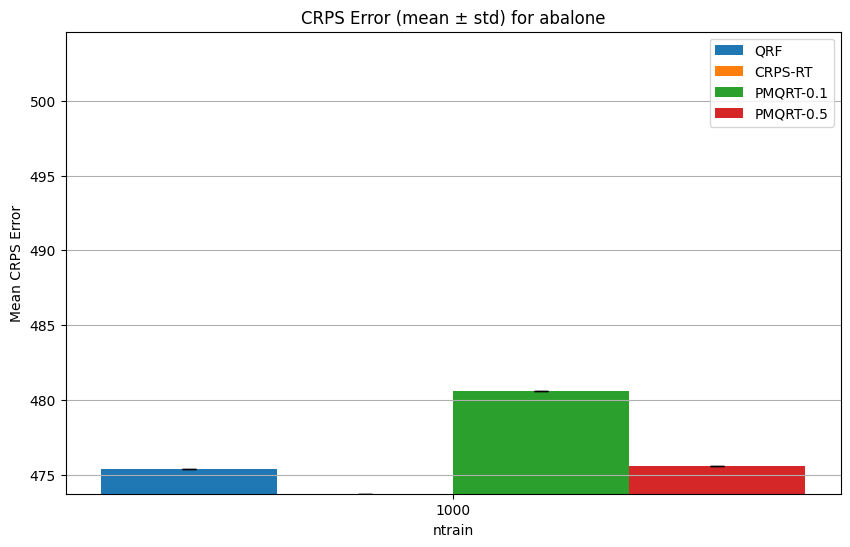

In [8]:
import matplotlib.pyplot as plt

for name_dataset in datasets:
    means = []
    stds = []
    for i_ntrain, ntrain in enumerate(lsntrain):
        # Collect errors across all ites for each method
        qrf_errors = dataset2QRFerrors[name_dataset][:, i_ntrain]
        crpsrt_errors = dataset2CRPSRTerrors[name_dataset][:, i_ntrain]
        pmqrt01_errors = dataset2PMQRT01errors[name_dataset][:, i_ntrain]
        pmqrt05_errors = dataset2PMQRT05errors[name_dataset][:, i_ntrain]

        method_means = [
            np.mean(qrf_errors),
            np.mean(crpsrt_errors),
            np.mean(pmqrt01_errors),
            np.mean(pmqrt05_errors)
        ]
        method_stds = [
            np.std(qrf_errors),
            np.std(crpsrt_errors),
            np.std(pmqrt01_errors),
            np.std(pmqrt05_errors)
        ]
        means.append(method_means)
        stds.append(method_stds)

    means = np.array(means)
    stds = np.array(stds)
    x = np.arange(len(lsntrain))
    width = 0.2
    method_labels = ['QRF', 'CRPS-RT', 'PMQRT-0.1', 'PMQRT-0.5']

    plt.figure(figsize=(10, 6))
    for i, label in enumerate(method_labels):
        plt.bar(x + i*width, means[:, i], width, yerr=stds[:, i], label=label, capsize=5)
    plt.xlabel('ntrain')
    plt.ylabel('Mean CRPS Error')
    plt.title(f'CRPS Error (mean ± std) for {name_dataset}')
    plt.xticks(x + 1.5*width, lsntrain)
    plt.legend()
    plt.grid(axis='y')
    min_val = means.min()
    plt.ylim(bottom=min_val)
    plt.show()